# 2.3 Clustering!

## 2.3.1: Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class. 2.3.3 : Run the algorithm on the data obtained from the dimensionality reduction.

Constructing the algorithm is a lot easier with an input(our data set we received after the dimensionality reductionp), this is why 2.3.1 and 2.3.3 are solved in one step. The algorithm will be called again later on with the optimal cluster size

First we have to import the necessary libraries

In [86]:
import pandas as pd
import numpy as np
#Libraries for the visulaization of our clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
#Library for scaling the dataframe
from sklearn.preprocessing import StandardScaler


We read in our data, the two columns that can't be used are dropped from the dataset

In [87]:
data = pd.read_csv(("/Users/damianzeller/Desktop/HS23/ADM/Homwork 4/file_2.2_correct.csv"))
data = data.drop('user_id', axis=1)
data = data.drop('Unnamed: 0', axis=1)

As we will be dealing with distances, we have to scale our data, in order to avoid, that some features have a bigger influence than others. It standardizes the features indepently by removing the mean and scaling to unit variance

In [88]:
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
data = pd.DataFrame(scaled, columns=data.columns)

We write a function that selects our first centroids randomly. This is done by just picking some datapoints. This function will return a dataframe. We want the centroids to be columns, so we transpose the dataframe before returning it.

In [89]:
# Randomly select centroids from the dataset
def random_centroids(data, k):
    centroids=data.sample(k)
    return centroids.T

We write our map function. This function will return the index of the closest centroid for each datapoint as a pandas series

In [90]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every centroid with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

Now we write our reduce function. It reallocates the centroids to the positon, that minimizes the distances of the datapoints that were assigned to the respective centroid.This function returns a dataframe, that is again transpozed as we want the centroids to be columns

In [91]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

The next step is not a an actual part of an algorithm, but as we want to visualize our results, in order to see if they are reasonable, we write another function to plot our clusters. We do this by making our data two dimensional.
The title of our plot is the current iteration, as we write the function in a way that it displays our clusters for each iteration, in order to see if the development makes sense.

In [92]:
#Visualize plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()
    

Now we have all the functions we need to pull our algorithm together. The first centroids are chosen randomly(random_centroids function). Afterwards each datapoint is assgined to a cluster(mapping function) and the new centroids of that clusters are getting computed(reduce function). This process is being repeated until the the centroids don't change anymore or the max_iterations criteria is met to avoid an infinte loop.The result of every iteration is always getting visualized(plot_clusters function) The number of the max_iterations is chosen arbitrarily, as well as the number of k(number of clusters). We just want to check if our algorithm is working.


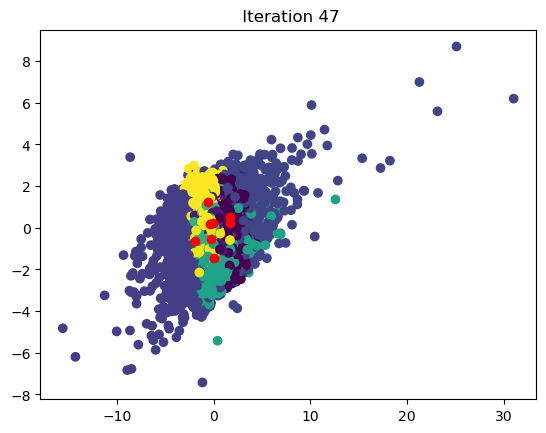

In [93]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=8
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

To do: Interpreation of result

## 2.3.2: Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

### Elbow method

First we are going to use the elbow method. The elbow method works a follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library. This will be repeated for a predefined amount of times (in our case 10) and only the smallest SSE value for the specific number of clusters is returned. Afterwards we have a list of SSE's for the different numbers of clusters and plot the against each other. Then we have to visually evaluate which is the perfect cluster size. The optimal cluster size is the one, where a bend in the slope(elbow) can be seen. As the evaluation is visual, it only works well for data that is well clustered and the bend can be easily identified.

We have to import some new libraries again

In [12]:
from sklearn.cluster import KMeans

In [29]:
kmeans_paras = {
  "init": "random", #The initial centroids are chosen randomly
  "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
  "random_state": 1, #Ensures the reproducibility of results
}

In [30]:
#Initialize a list of SSE's
sse = []
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(1, 16): 
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Appends the SSE to the list
    sse.append(kmeans.inertia_)

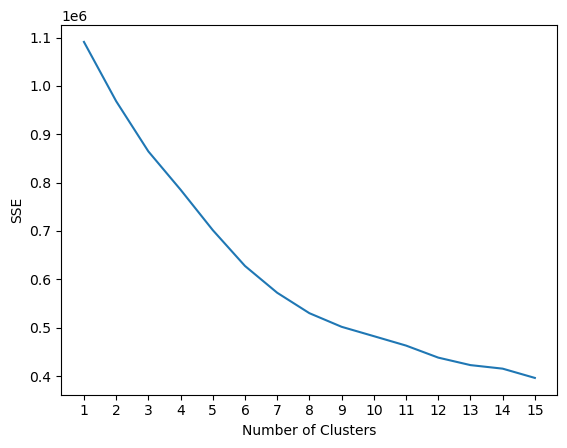

In [32]:
#Visualize
#Plot the SSE values against the number of clusters
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
#Name the x-/ and y-achsis
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#Show the plot
plt.show()

We really have problems identifying the 'elbow'. It could be at 7,8 or 9


### Silhouette method

Now we are going to use the Silhouette method. It works as follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library.This will be repeated for a predefined amount of times (in our case 10) and for the smallest SSE value for the specific number of clusters the Sihlouette score gets computed.The Silhouette score is a ratio of how similar a sample is to its own cluster compared to other clusters. It ranges from -1 to 1 and indicates how well clustered the data is. The sihlouette scores are stored in a dictionnary as values with the corresponding  number of clusters as key. To find the optimal number of clusters we have to extract the key of the highest score from the dictionnary.

In [16]:
from sklearn.metrics import silhouette_score

In [25]:
kmeans_paras = {
 "init": "random", #The initial centroids are chosen randomly
 "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
 "random_state": 1, #Ensures the reproducibility of results
}

In [26]:
#Initialize the dictionnary
silhouette_scores = {}
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(2, 16):
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Calculates the Silhouette score
    score = silhouette_score(data, kmeans.labels_)
    # Stores the sihlouette score with the number of clusters as key in a dictionnary
    silhouette_scores[k] = score
    print(score)

0.15076673550558237
0.17785472092786292
0.187178477838173
0.18665733321232644
0.19899683562525106
0.20664219617323257
0.2061659746742397
0.1996963878557684
0.201006644165683
0.1975974495091626
0.19856366486811083
0.19805497128658317
0.19981480951435399
0.20233638644697732


In [27]:
#Extract the number of clusters with the highest score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)

In [28]:
optimal_k

7

According to the Silhouette score our optimal cluster size is 7.

The evaluate the optimal amount of clusters we decide to go with the Sihlouette method. We do this mainly for the reason, that we can can perfectly see the weakness of the elbow method in our case. Our clusters are quite weak, which is also displayed by the low sihlouette scores we get. This means that it is really hard to visually find the
'elbow' in our plot. It could be argued, that it is also at a cluster size of seven, but can't be clearly evaluated. The disadvantage of the Silhouette score is, that it has a way longer running time than the elbow method.

Now we run our k-means algorithm as well with the optimal cluster size of 7.

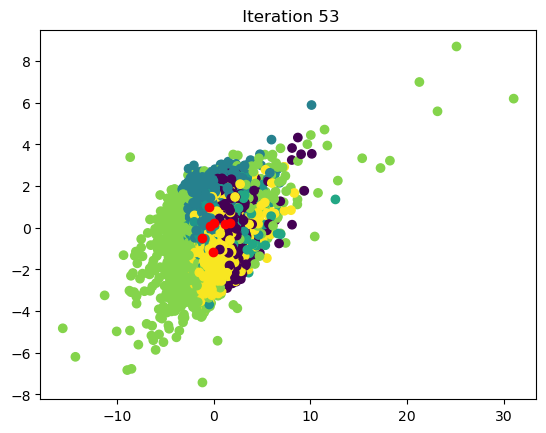

In [94]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=7
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

## 2.3.4:Implement K-means++ from scratch and explain the differences with the results you got earlier.

The K-means++ algorithm differs from the k-means algorithm in the way the initial centroids are chosen. Instead of choosing all the initial centroids randomly, this is only done for the first one. Afterwards the datapoints get weights that are proportional to the distance to the nearest centroid. The next centroid is then chosen (randomly) with respect to the probabilities. This makes the algorithm way more efficient.

In order to write the new random_centroids function, which creates the initial centroids, we have to first write two helping functions

The first helping function calculates the squared distance between a centroid and each datapoint. It returns a pandas series.

In [96]:
def calco_distances(centroid, data):
    distances = data.apply( lambda row : ((centroid-row)**2).sum(axis=1), axis=1)
    #distances = data.apply(lambda row: np.sum((centroid - row)**2), axis=1)
    return distances

The next helping function chooses the next centroid by choosing random with respect to the probabilities that are proprotional to the distance to the nearest centroid.

In [97]:
def get_centroid(distances):
    #Assigning the weights for the probabilities: They get assigned the distance. The reshape is necessary as they were a list of lists before which was not compatible with the random choice function
    weights = distances.to_numpy().reshape(-1)
    #Get new centroid with respect to probabilities. probabilitiy= distance/ sum of all distances
    centroid = np.random.choice( np.arange(0,len(data)), p=weights/sum(weights))
    #We return centroid as a dataframe and transpose it 
    return pd.DataFrame(data.iloc[centroid,]).T

Now we have our helping functions and can pull the new random_centroid function together

In [98]:
def random_centroids(data, k):
    #We initialize dataframes to store our centroids and distances
    centroids= pd.DataFrame()
    df_distances = pd.DataFrame()
    #We loop over the number of needed centroids
    for i in range(k):
        # if condition for creation of first centroid
        if len(centroids) == 0:
            #randomly choose a datapoint as first centroid
            centroid = data.sample(n=1).copy()
        #else condition, that always gets entered after the first centroid was created
        else:
            distances = df_distances.min(axis=1)
            centroid = get_centroid(distances)
        centroids = pd.concat([centroids, centroid])
        # creating a column in our df_distances dataframe that stores the distances of each datapoint to the respective centroid
        df_distances[str(i)] = calco_distances(centroid, data)
    return centroids.T

Besides the new function to create the initial centroids, the other functions remain the same as for the k-means algorithms. Therefor there won't be any further comments on them

In [99]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every row with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

In [100]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

In [101]:
#Visualize plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()

Now we run our K++ means algorithm

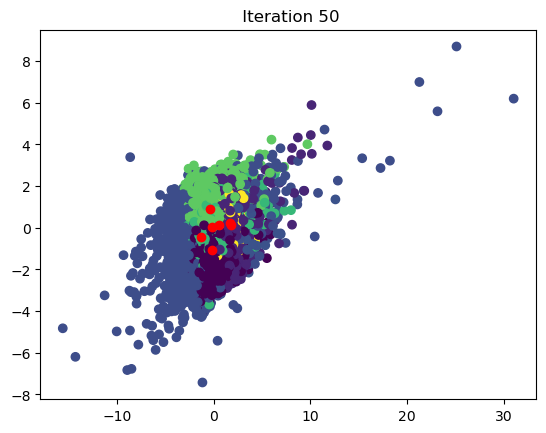

In [102]:
max_iterations= 100
k=7
centroids= random_centroids(data, k)
old_centroids= pd.DataFrame()
iteration=1
while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids= centroids
    
    clusters= mapping(data, centroids)
    centroids= reduce(data, clusters, k)
    plot_clusters(data, clusters, centroids, iteration)
    iteration+=1

We can't see a significant difference in the clustering compared to the K-means algorithm, which is very likely due to the fact that our data is not suitable for partitional clustering

## 2.3.5: Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

Here is the implemantation of Chat GPT, adjusted to our data:

In [108]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

In [109]:
data = pd.read_csv(("/Users/damianzeller/Desktop/HS23/ADM/Homwork 4/file_2.2_correct.csv"))
data = data.drop('user_id', axis=1)
data = data.drop('Unnamed: 0', axis=1)

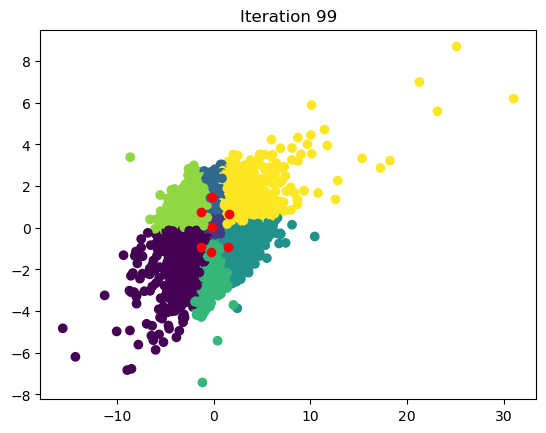

In [110]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Fit PCA on the original data
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(data_2d)

# Fit PCA on the cluster centers
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)

for iteration in range(100):
   clear_output(wait=True)
   plt.title(f'Iteration {iteration}')
   plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=kmeans.labels_)
   plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c='red')
   plt.show()

There is no condition involved in the code to stop the loop, that's why we just go with 100 iterations. We can observe, that in the end the clusters do not change anymore

The clustering looks a lot better, than the one we did